# Linear Modeling - Simple

In linear modeling, we are interested in modeling a relationship between measures by defining a linear equation that fits the data

![lm_uni.png](images/lm_uni.png)

We will explore how we can
- obtain the $b_0$ and $b_1$ terms for the linear equation that fits the data
- determine if the coefficients are significant
- estimate the uncertainty in the estimates for $b_0$ and $b_1$
- estimate how well the model fits the data
- interpret diagnostic plots of the model fit

---
## Data preparation

We will use the dataset from the Framingham study, which was a long term study of cardiovascular disease about subjsects in Framingham, USA. In this dataset ~4000 subjects were followed up and clinical data and chronic heart disease outcomes were examined longitudinally over > 10 years

Variables include:
- `male` : 0 = female, 1 = male
- `age` : Age at the time of medical examination in years.
- `education` : 1 = Some high school, 2 = high school/GED, 3 = some college/vocational school, 4 = college
- `currentSmoker`: Current cigarette smoking at the time of examinations
- `cigsPerDay`: Number of cigarettes smoked each day
- `BPmeds`: Use of Anti-hypertensive medication at exam
- `prevalentStroke`: Prevalent Stroke 
- `prevalentHyp`: Prevalent Hypertensive
- `diabetes`: Diabetic according to criteria of first exam treated
- `totChol`: Total cholesterol (mg/dL)
- `sysBP`: Systolic Blood Pressure (mmHg)
- `diaBP`: Diastolic blood pressure (mmHg)
- `BMI`: Body Mass Index, weight (kg)/height (m)^2
- `heartRate`: Heart rate (beats/minute)
- `glucose`: Blood glucose level (mg/dL)

We will build a model with `sysBP` as a response and explore its relationship with `BMI`. In this case, we will filter out cases that are on antihypertensive medication `BPMeds == 0`

In [1]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na

BMI_sysBP <- data %>% select(BMI, sysBP)

head(BMI_sysBP)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 4240 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


BMI,sysBP
<dbl>,<dbl>
26.97,106.0
28.73,121.0
25.34,127.5
28.58,150.0
23.10,130.0
30.30,180.0


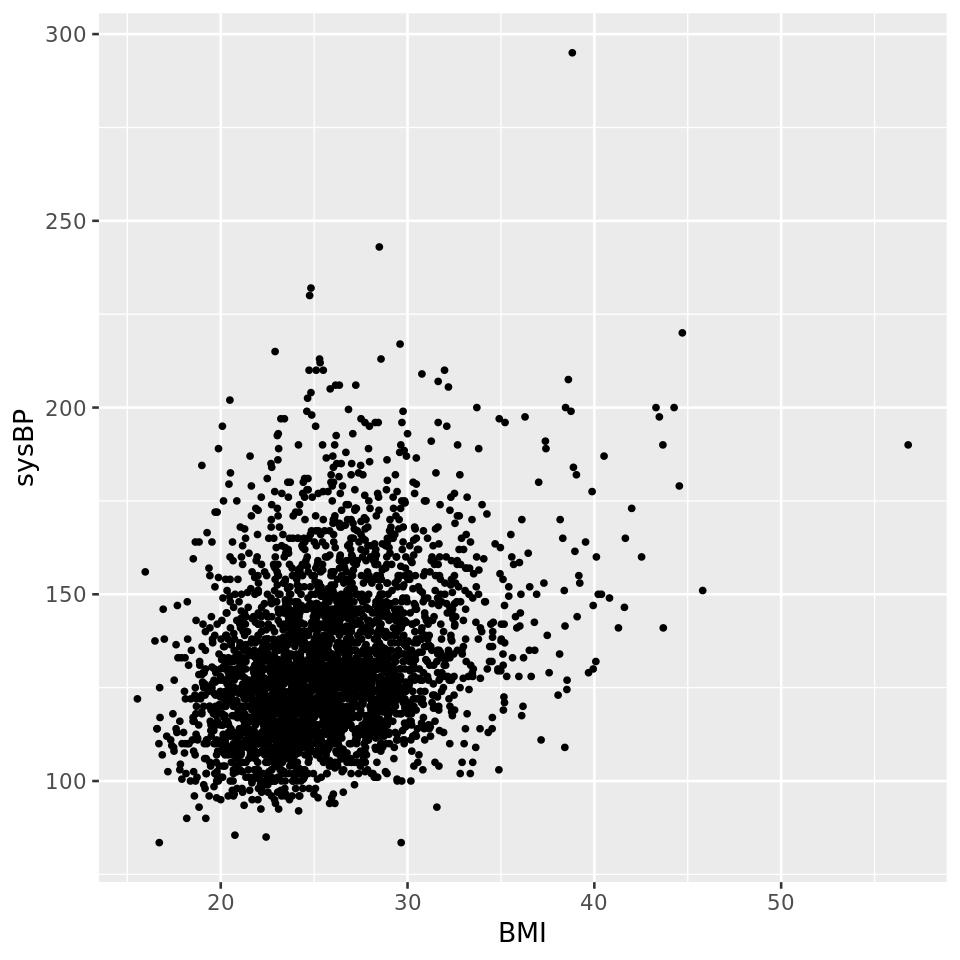

In [2]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

BMI_sysBP %>% ggplot(aes(x=BMI, y=sysBP)) + 
                geom_point() +
                theme_grey(base_size=16)

It appears there is a possibly a linear relationship between systolic BP and BMI

---
## How can we estimate the linear relationship?

We can model the data between the 2 quantitative variables as a linear equation

$$y=b_0 + b_1x$$

$$
\begin{align}
\text{where } y &= \text{outcome or response}\\
x &= \text{covariate}\\
b_0 &= \text{intercept}\\
b_1 &= \text{slope (coefficient)}
\end{align}
$$

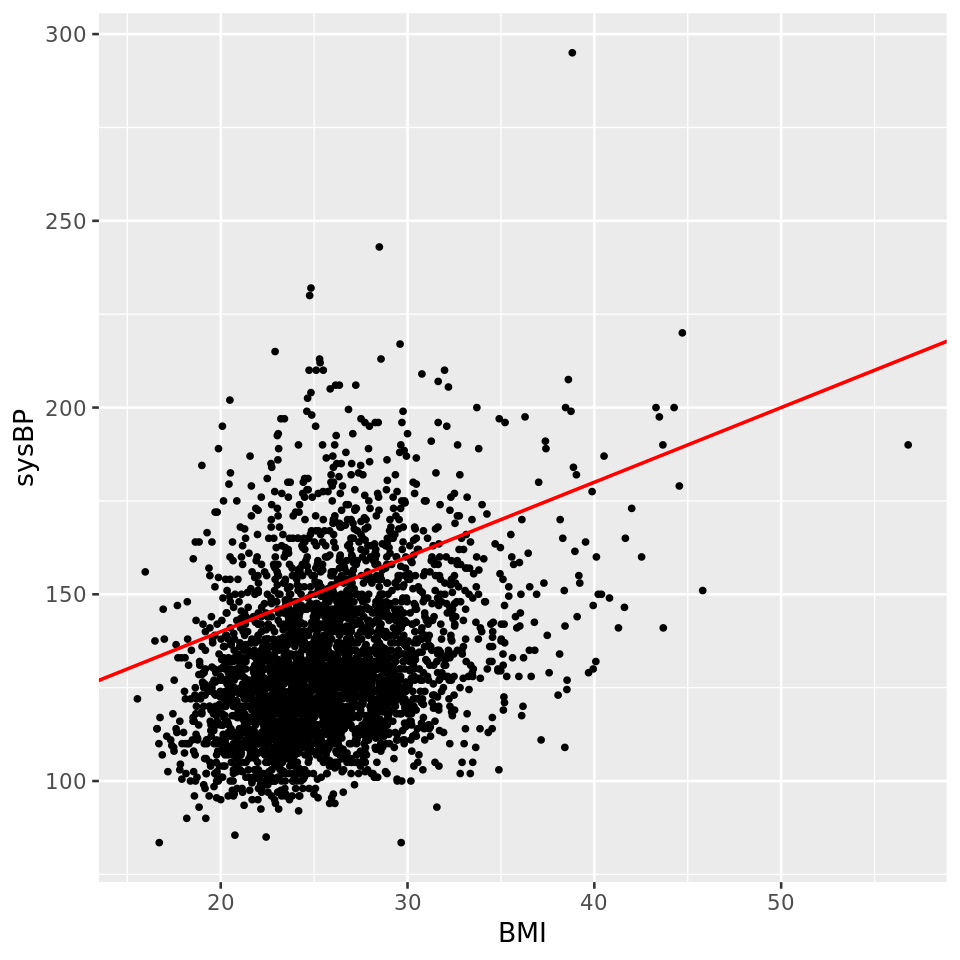

In [3]:
# define b0 (intercept) and b1 (slope)
b0 <- 100
b1 <- 2

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

BMI_sysBP %>% ggplot(aes(x=BMI, y=sysBP)) + 
                geom_point() + 
                geom_abline(intercept=b0, # line defined by slope/intercept
                            slope=b1, 
                            color="red", 
                            size=1) + 
                theme_grey(base_size=16)

To estimate how well a line fits the data points, we can consider the sum of squared differences between the data points and the line specified by the intercept $b_0$ and slope $b_1$
- Specify the intercept $b_0$ and slope $b_1$ to get a linear equation $\hat{y}=b_0 + b_1x$
- For each $x$ data point, calculate $\hat{y}$ using the linear equation
- Calculate the squared differences between $\hat{y}$ and $y$ from the data
- Calculate the sum of squared differences $SS$


![regression_ss.png](images/regression_ss.png)

We'll demonstrate this by first making a function `sum_squares` to calculate the sum of squared differences $SS$

In [4]:
sum_squares <- function(parameters, data, y, x) { 
    
    # b0 and b1 passed in as a vector (we need this requirement later)
    b0 <- parameters[1]
    b1 <- parameters[2]
    
    data %>% 
    rename(y=!!y,       # y = dependent variable
           x=!!x) %>%   # x = independent variable
    mutate(y_predict = b0 + b1 * x,
           squared_diff = (y_predict - y)^2) %>%
    summarize(sum_squared_diff = sum(squared_diff)) %>%
    pull(sum_squared_diff) %>%
    return
    
    }

We can specify `b0` and `b1` and calculate the sum of squared differences

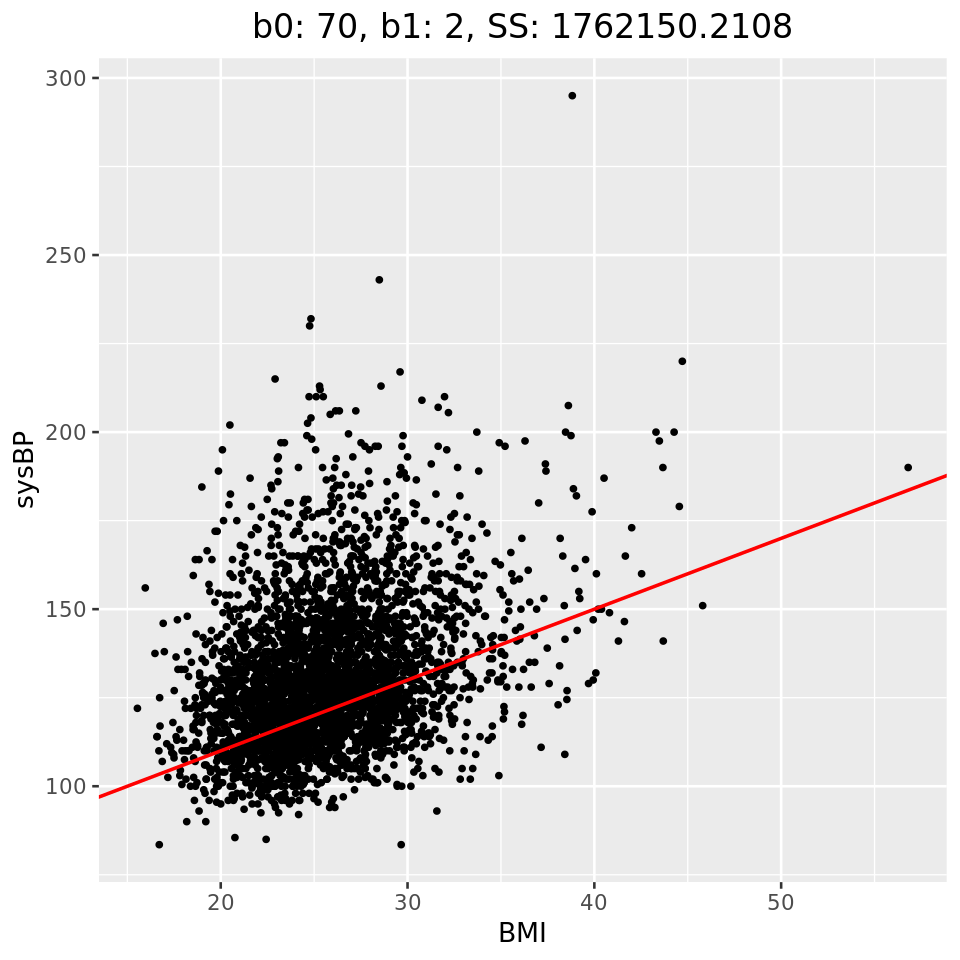

In [5]:
b0 <- 70
b1 <- 2
ss <- sum_squares(parameters = c(b0, b1),
                  data = BMI_sysBP, 
                  y = "sysBP", 
                  x = "BMI")

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

BMI_sysBP %>% ggplot(aes(x=BMI, y=sysBP)) + 
                geom_point() + 
                geom_abline(intercept=b0, slope=b1, color="red", size=1) + 
                ggtitle(glue::glue("b0: {b0}, b1: {b1}, SS: {ss}")) + # add description
                theme_grey(base_size=16) +
                theme(plot.title = element_text(hjust = 0.5, size=20))

The goal of getting the best fit is to find the combination of $b_0$ and $b_1$ values that minimizes this sum squared of differences $SS$

$$ \hat{y}_{i} = b_0 + b_1 x_{i} $$

$$
\begin{align}
\widehat{b_0}, \widehat{b_1} &=\underset{b_0, b_1}{\arg \min } \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}\\
&=\underset{b_0, b_1}{\arg \min } \sum_{i=1}^{n}\left(y_{i}-b_0-b_1 x_{i}\right)^{2}
\end{align}
$$

We want to minimize the sum of squares to find the best fitting line for the data points. To explore this, we can calculate the sum of squares when we vary $b_0$ (intercept) and $b_1$ (slope)

- To do this, we create a 2x2 grid of $b_0$ and $b_1$ values, then calculate the sum of squared differences for each combination

In [6]:
# create a 2x2 grid of b0 and b1 values
# calculate the sum of squared differences for each combination

grid <- expand_grid(b0 = seq(0,150, by=5), 
                    b1 = seq(0,5, by=0.1)) %>%
        rowwise %>%
        mutate(ss = sum_squares(c(b0, b1), 
                                data=BMI_sysBP, 
                                x="BMI", 
                                y="sysBP"))

head(grid)
tail(grid)

b0,b1,ss
<dbl>,<dbl>,<dbl>
0,0.0,62737626
0,0.1,60347462
0,0.2,58005313
0,0.3,55711179
0,0.4,53465060
0,0.5,51266955


b0,b1,ss
<dbl>,<dbl>,<dbl>
150,4.5,65890557
150,4.6,68396529
150,4.7,70950515
150,4.8,73552517
150,4.9,76202533
150,5.0,78900565


We can visualize the sum of squared differences values in the grid for the different $b_0$ and $b_1$ parameters

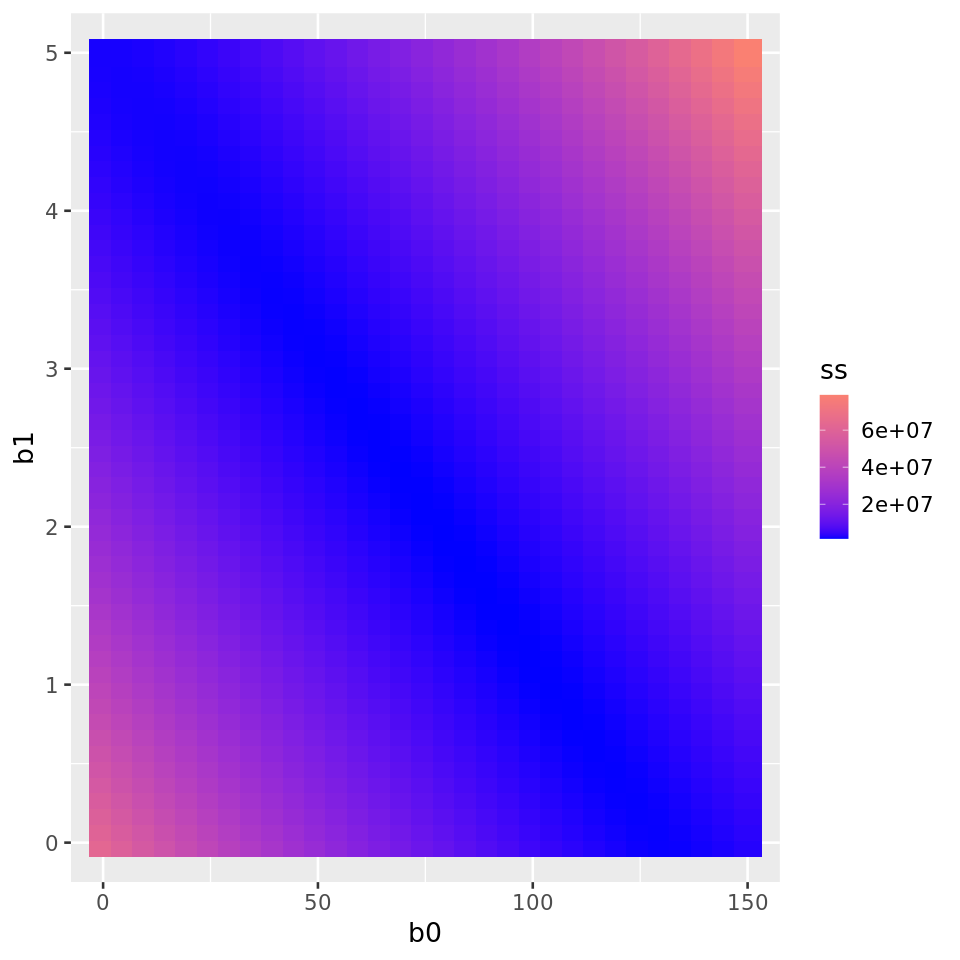

In [7]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

grid %>% ggplot(aes(x=b0, y=b1, color=ss)) + 
           geom_point(shape=15,size=7.5) +
           scale_color_gradient(low = "blue", high = "salmon") +
           theme_grey(base_size=16)

To find the $b_0$ and $b_1$ parameters that minimize the sum of squared differences $SS$, we can use an optimization function `optim`

In [8]:
optimal <- optim(par = c(0,0),     # parameter starting point b0=0, b1=0
                 sum_squares,      # use sum_squares function (takes par as argument) 
                 data=BMI_sysBP, 
                 x="BMI", 
                 y="sysBP") 

b0 <- optimal$par[1]
b1 <- optimal$par[2]

glue::glue("b0: {b0}\n b1: {b1}") %>% print

b0: 87.0964444904761
b1: 1.7200538117663


We can visualize the location of the optimal $b0$ and $b1$ parameters

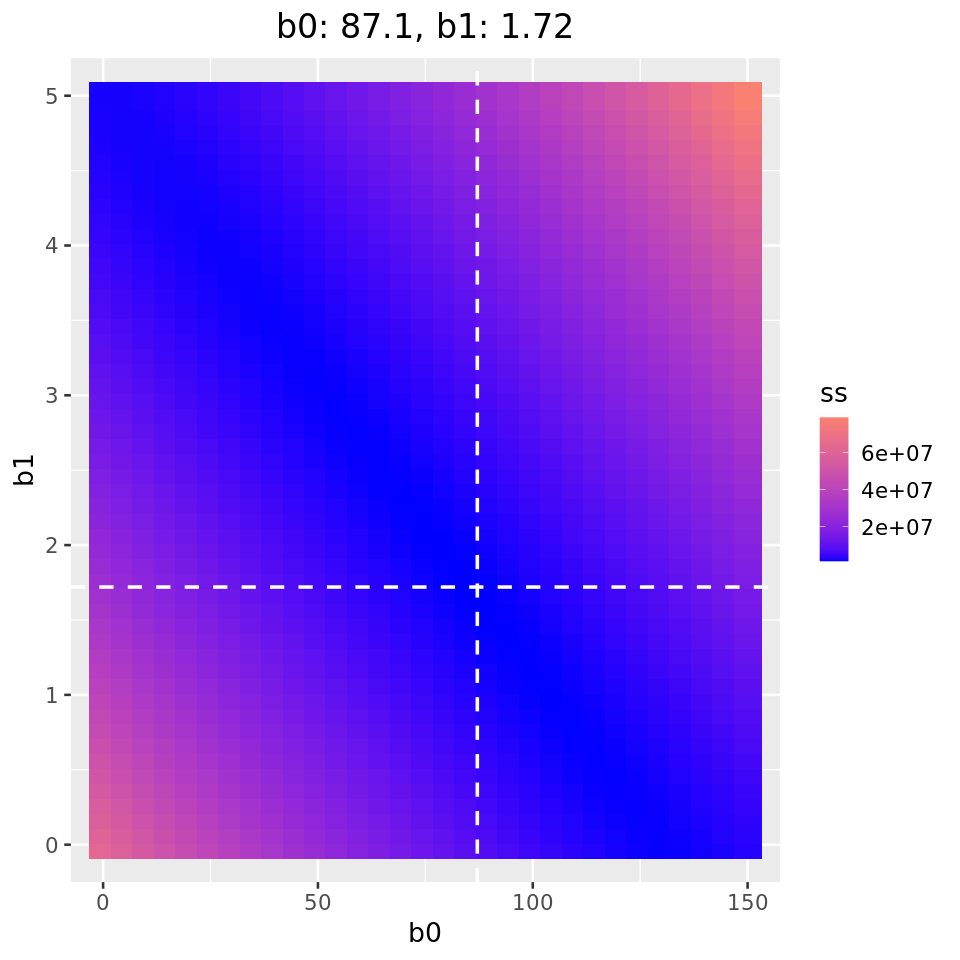

In [9]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

grid %>% ggplot(aes(x=b0, y=b1, color=ss)) + 
              geom_point(shape=15,size=7.5) +
              geom_vline(xintercept = b0,color="white",linetype="dashed",size=1) +
              geom_hline(yintercept = b1,color="white",linetype="dashed",size=1) +
              scale_color_gradient(low = "blue", high = "salmon") +
              ggtitle(glue::glue("b0: {round(b0,2)}, b1: {round(b1,2)}")) +
              theme_grey(base_size=16) +
              theme(plot.title = element_text(hjust = 0.5, size=20))

We can plot the line using the optimal $b_0$ and $b_1$ parameters that minimize the sum of squared differences $SS$

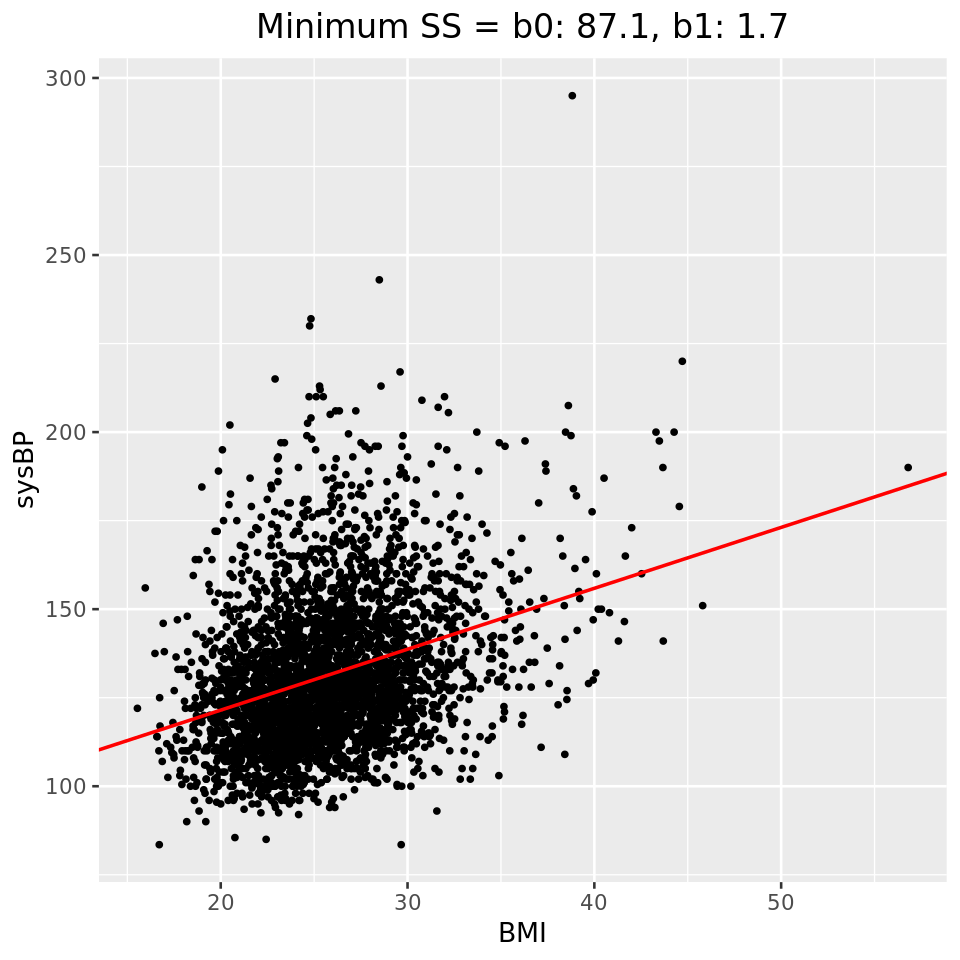

In [10]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data %>% ggplot(aes(x=BMI, y=sysBP)) + 
           geom_point() + 
           geom_abline(intercept = b0, slope = b1, color = "red", size=1) +
           ggtitle(glue::glue("Minimum SS = b0: {round(b0,1)}, b1: {round(b1,1)}")) +
           theme_grey(base_size=16) +
           theme(plot.title = element_text(hjust = 0.5, size=20))

## Using the `lm` function for linear modeling

For linear regression modeling, we will use the `lm` function
- `lm(response ~ explanatory variable(s), data)`

Note that the following nomenclature are often used interchangeably
- The response is also known as the dependent variable
- The explanatory variable is also known as the independent variable or covariate


In [11]:
# build model
fit_BMI <- lm(sysBP ~ BMI, BMI_sysBP) # build model

# show coefficients
broom::tidy(fit_BMI) %>% select(term, estimate)

term,estimate
<chr>,<dbl>
(Intercept),87.068295
BMI,1.721042


From the $b_0$ intercept  and $b_1$ slope terms, we have the linear equation relating systolic BP and BMI from the data

$$y = b_0 + b_1 x$$

$$\text{sysBP} = 87.07_\text{intercept} + 1.72_\text{BMI} \times \text{BMI}$$

Although we have obtained the coefficients for the model, we do not know 
- if the estimates could have arisen by random chance 
- the range of uncertainty of the estimates

---
## 1. Resampling approach

### Significance testing of coefficients

To get an intuition of the null hypothesis test, we will use the resampling approach
- To do this, we randomly mix the values in the data and do this multiple times to generate a _dataset that represents the null hypothesis_
- We then calculate the coefficients $b_0$ and $b_1$ from the permuted data to generate the null distribution of coefficients
- Finally, we calculate the _p-value_, which is the probability we  find coefficients $b_0$ and $b_1$ in the null distribution that is equal/greater than the  observed coefficient values

#### 1.1. Calculate the $b_0$ and $b_1$ coefficients

We obtain the coefficients using the `lm` function

In [12]:
fit_BMI <- lm(sysBP ~ BMI, BMI_sysBP) # buiild model

obs_b0 <- fit_BMI$coefficients[1]  # 1st = intercept 
obs_b1 <- fit_BMI$coefficients[2]  # 2nd = slope

obs_b0
obs_b1

(Intercept) 
    87.0683

BMI 
1.721042

#### 1.2. Generate a null distribution by resampling

First, we will generate 1000 samples from the data by randomly permuting the `sysBP` and `BMI` values independently using the `infer` library

In [13]:
library(infer)

num_resample <- 1000

permute <- data %>%  
           specify(sysBP ~ BMI) %>%
           hypothesize(null = "independence") %>% 
           generate(reps = num_resample, type = "permute")

head(permute)

sysBP,BMI,replicate
<dbl>,<dbl>,<int>
125,26.97,1
165,28.73,1
113,25.34,1
116,28.58,1
154,23.10,1
114,30.30,1


We can plot a sample of the randomly permuted dataset and include a linear regression line using the `geom_smooth` function and specifying `method="lm"` to illustrate the intercept and slope estimates

`geom_smooth()` using formula 'y ~ x'



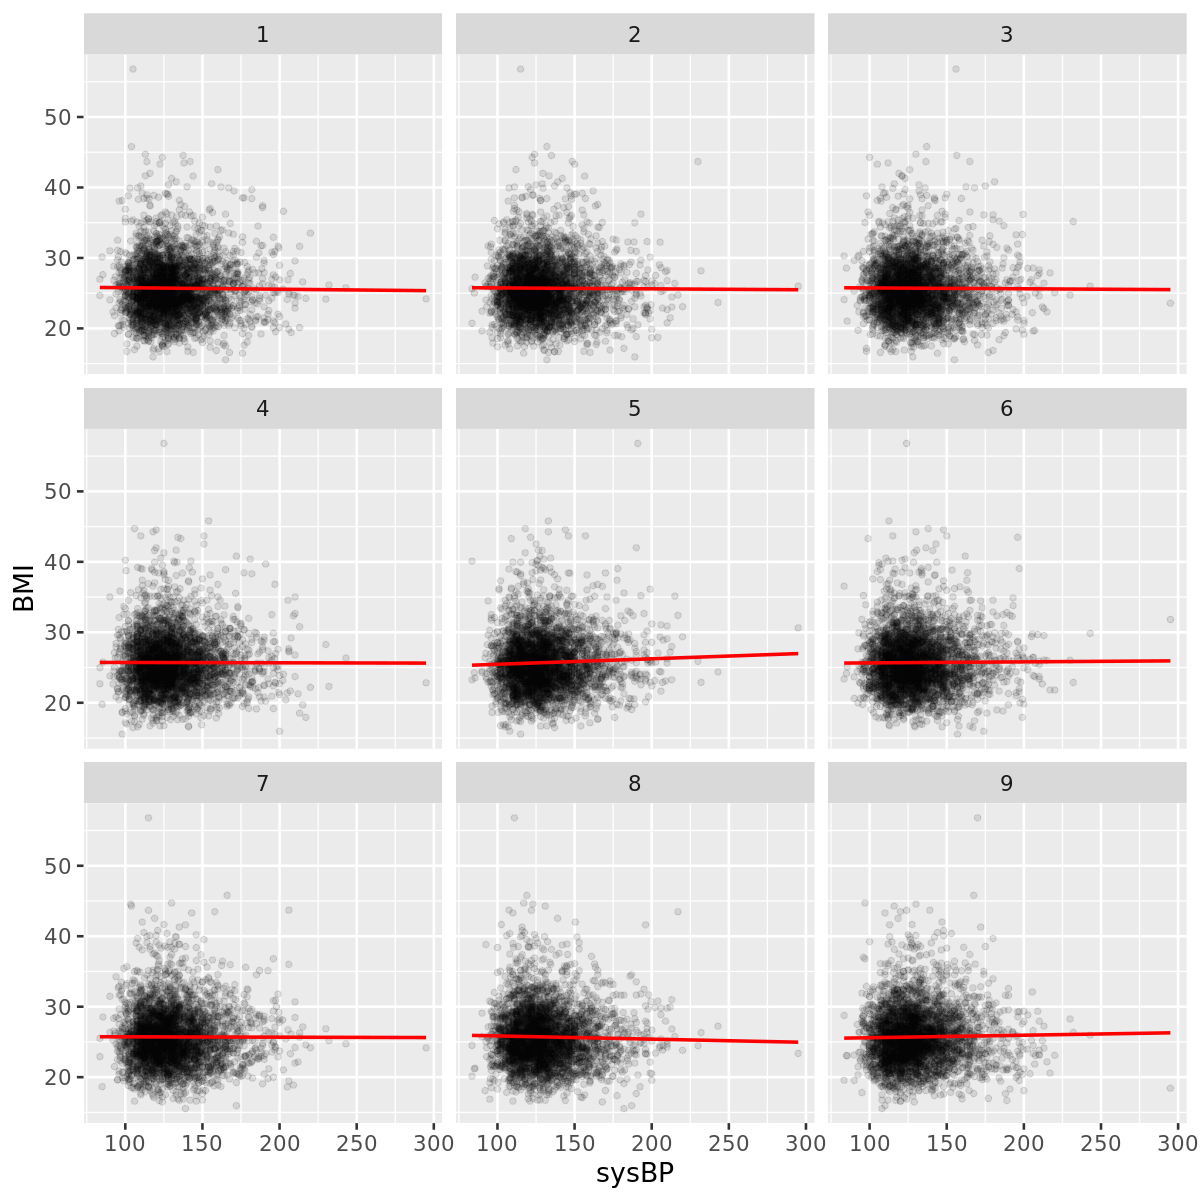

In [14]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

permute %>% filter(replicate<=9) %>%
            ggplot(aes(x=sysBP, y=BMI)) + 
              geom_point(alpha=0.1) + 
              geom_smooth(method="lm",se=FALSE, color="red") +
              facet_wrap(~replicate) +
              theme_grey(base_size=16)

We calculate the $b_0$ and $b_1$ coefficients for each replicate by using the `lm` function

In [15]:
resample <- permute %>% 
            group_by(replicate) %>%
            summarize(b0 = lm(sysBP ~ BMI)$coefficients[1],
                      b1 = lm(sysBP ~ BMI)$coefficients[2])

head(resample)

replicate,b0,b1
<int>,<dbl>,<dbl>
1,132.8394,-0.05946277
2,132.2640,-0.03707828
3,132.1917,-0.03426669
4,131.6404,-0.01282119
5,125.7492,0.21634871
6,130.2670,0.04060602


We now have a distribution of both coefficients under the assumption that there is no relationship between `sysBP` and `BMI`

#### 1.3. Use the null distribution to calculate the p-value

Now that we have the null distribution of the coefficients, we can check if any of these values exceed the observed coefficients ```obs_b0``` and `obs_b1`

In [16]:
resample <- resample %>% 
            mutate(exceed_b0 = if_else(abs(b0) <= abs(obs_b0), "Y","N") %>%
                            factor(levels=c("Y","N")),
                   exceed_b1 = if_else(abs(b1) >= abs(obs_b1), "Y","N") %>%
                            factor(levels=c("Y","N")),
                  ) 
 
resample %>% sample_n(10)

replicate,b0,b1,exceed_b0,exceed_b1
<int>,<dbl>,<dbl>,<fct>,<fct>
293,130.5864,0.028179419,N,N
206,135.1785,-0.150452397,N,N
529,131.6213,-0.012078528,N,N
211,130.9952,0.012277520,N,N
291,129.1678,0.083364238,N,N
115,132.8759,-0.060882973,N,N
540,131.5457,-0.009135116,N,N
698,134.3348,-0.117634710,N,N
507,129.7824,0.059456624,N,N


We can visualize the null distribution of $b_0$ and $b_1$ coefficients and indicate those values that are equal or exceed the the observed  coefficients

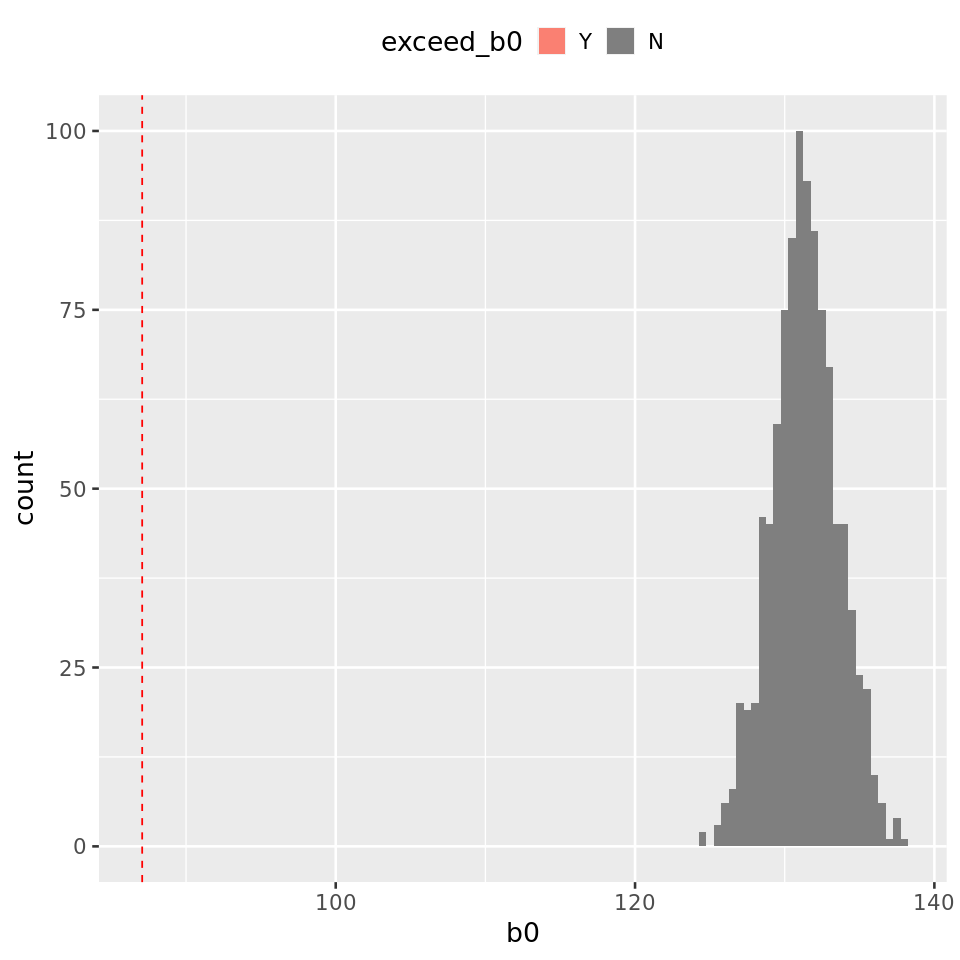

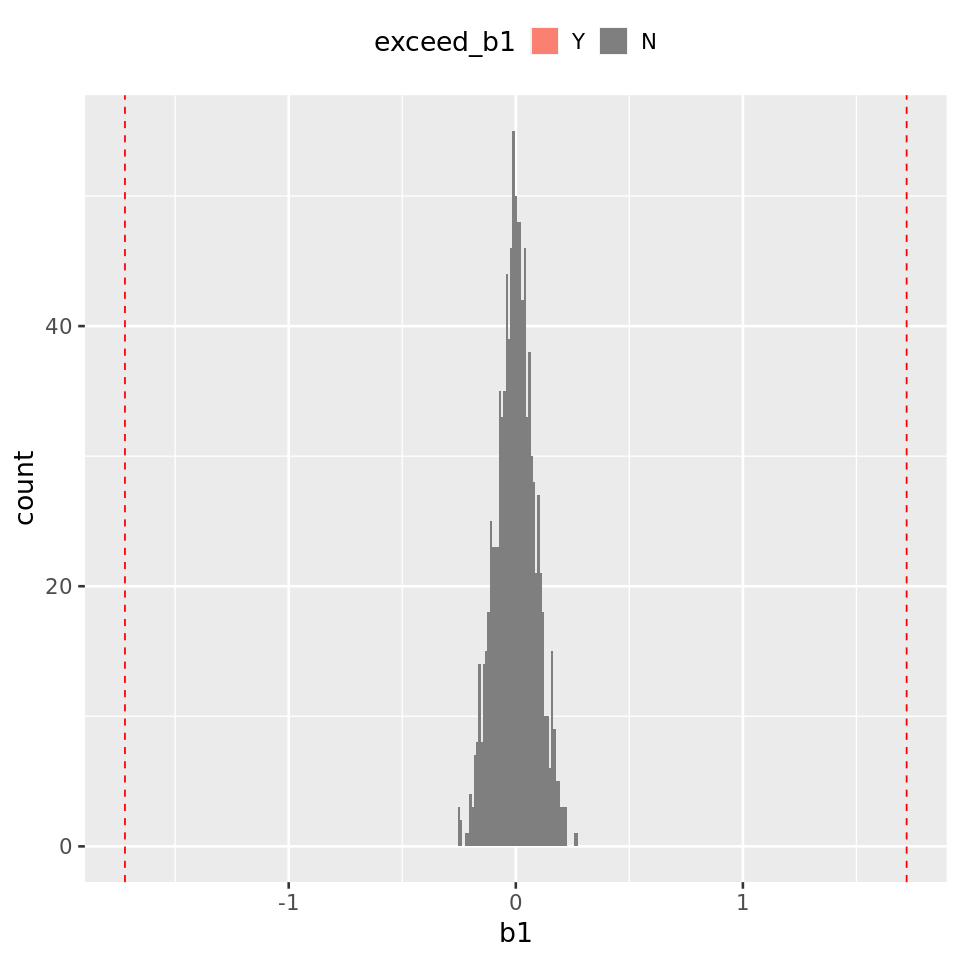

In [17]:
# set plot dimensions

options(repr.plot.width=8, repr.plot.height=8)

resample %>% ggplot(aes(x=b0, fill=exceed_b0)) + 
               geom_histogram(binwidth=0.5) + 
               geom_vline(xintercept = obs_b0, color = "red", linetype="dashed") +
               scale_fill_manual(values=c("salmon", "grey50"), 
                                 labels=c("Y","N"), drop=FALSE) +
               theme_grey(base_size=16) +
               theme(legend.position = "top")

resample %>% ggplot(aes(x=b1, fill=exceed_b1)) + 
               geom_histogram(binwidth=0.01) + 
               geom_vline(xintercept = obs_b1, color = "red", linetype="dashed") +
               geom_vline(xintercept = -obs_b1, color = "red", linetype="dashed") +
               scale_fill_manual(values=c("salmon", "grey50"), 
                                 labels=c("Y","N"), drop=FALSE) +
               theme_grey(base_size=16) +
               theme(legend.position = "top")

Finally, we can get the _p-value_ by calculating how many times the $b_0$ and $b_1$ coefficients in the null distribution is equal/exceeds the observed coefficients

In [18]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed_b0 == "Y", 1,0) %>% sum,
                       p_value_b0 = num_exceed/num_resample)

resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed_b1 == "Y", 1,0) %>% sum,
                       p_value_b1 = num_exceed/num_resample)

num_resample,num_exceed,p_value_b0
<int>,<dbl>,<dbl>
1000,0,0


num_resample,num_exceed,p_value_b1
<int>,<dbl>,<dbl>
1000,0,0


As the p-values are small, the coefficients we obtain in the linear model are unlikely to be consistent with the null hypothesis. Thus, the coefficients in the linear model are unlikely to be due to random chance

### Confidence interval by bootstrap

We will use the resampling approach to obtain the confidence interval of the coefficients
- To do this, we will take bootstrap samples (sampling with replacement) from the dataset
- We then calculate the $b_0$ and $b_1$ coefficients for each of the bootstrap samples to obtain a bootstrapped distribution of coefficient values
- Finally we obtain the 95% confidence interval of the coefficients by finding the 2.5% and 97.5% percentile values from the bootstrapped distribution

#### 1. Generate bootstrap samples of dataset

To get the confidence intervals of the coefficients, we generate bootstrap samples of the dataset (resampling with replacement) using the `infer` library

In [19]:
bootstrap <- data %>% specify(sysBP ~ BMI) %>%
             generate(reps=1000, type="bootstrap")

head(bootstrap)
tail(bootstrap)

replicate,sysBP,BMI
<int>,<dbl>,<dbl>
1,106.0,26.79
1,167.5,27.73
1,114.0,16.59
1,111.0,29.47
1,115.0,27.72
1,152.0,24.47


replicate,sysBP,BMI
<int>,<dbl>,<dbl>
1000,135.0,20.72
1000,152.5,24.10
1000,113.5,25.63
1000,116.0,22.15
1000,146.0,24.59
1000,116.0,26.09


We calculate the $b_0$ and $b_1$ coefficients for each replicate in the bootstrap sample

In [20]:
boot_coef <- bootstrap %>% 
             group_by(replicate) %>%
             summarize(b0 = lm(sysBP ~ BMI)$coefficients[1],
                       b1 = lm(sysBP ~ BMI)$coefficients[2])

head(boot_coef)
tail(boot_coef)

replicate,b0,b1
<int>,<dbl>,<dbl>
1,91.02694,1.546979
2,89.58758,1.626752
3,85.77936,1.768388
4,89.47750,1.632006
5,86.14274,1.770679
6,86.04999,1.774496


replicate,b0,b1
<int>,<dbl>,<dbl>
995,89.77437,1.635140
996,86.96961,1.738007
997,85.72618,1.769878
998,87.63564,1.710153
999,89.17602,1.629571
1000,85.89213,1.772169


#### 1.2. Use the bootstrap distribution to calculate the confidence interval

We can use the `quantile` function to find the 2.5 and 97.5 percentile values for the lower and upper limits of the 95% confidence interval and visualize the limits on the bootstrap distribution

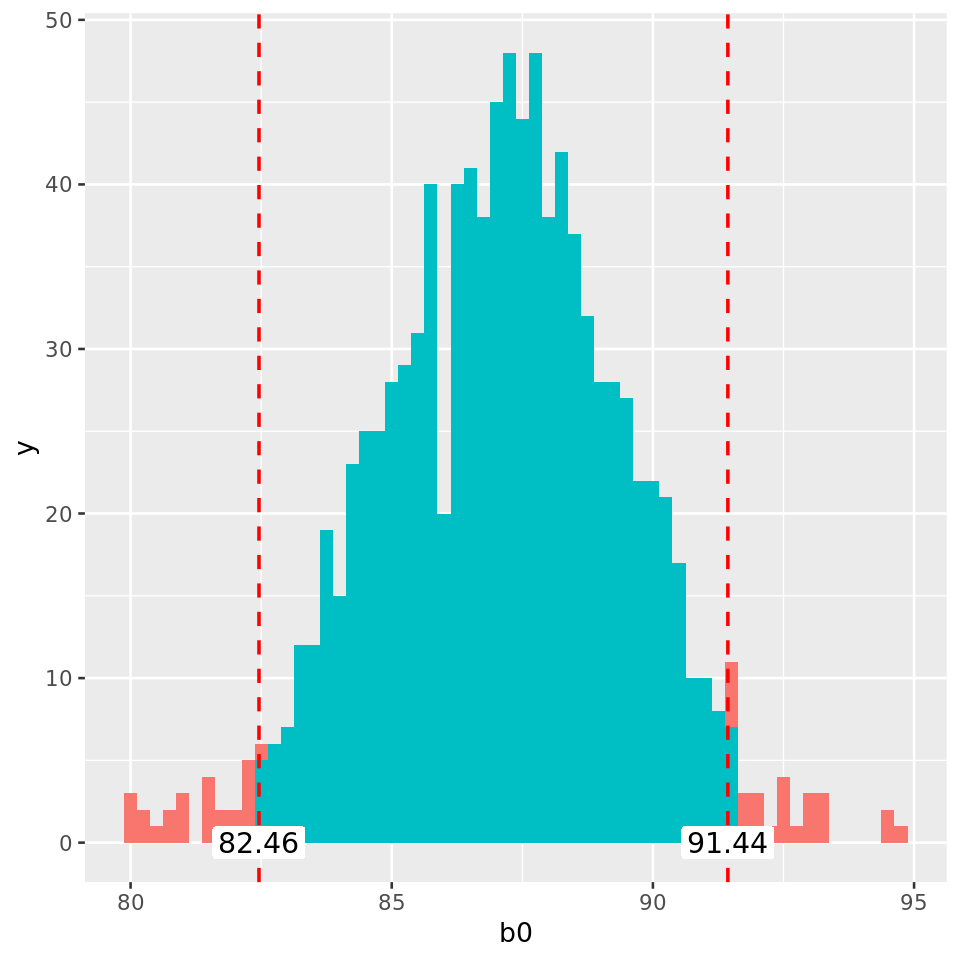

In [21]:
# Calculate the 2.5 and 97.5 percentiles for b0

boot_b0_lower <- quantile(boot_coef$b0, 0.025)
boot_b0_upper <- quantile(boot_coef$b0, 0.975)

# Visualize the 95% confidence interval for b0

boot_coef %>% ggplot(aes(x=b0)) + 
              geom_histogram(aes(fill=(b0>=boot_b0_lower &
                                       b0<=boot_b0_upper)),
                             binwidth=0.25) +
              geom_vline(xintercept = boot_b0_lower, color="red", linetype="dashed", size=1) +
              geom_vline(xintercept = boot_b0_upper, color="red", linetype="dashed", size=1) +
              annotate("label", x= boot_b0_lower, y = 0, label=round(boot_b0_lower,2), size=6, label.size=NA) +
              annotate("label", x= boot_b0_upper, y = 0, label=round(boot_b0_upper,2), size=6, label.size=NA) +  
              theme_grey(base_size=16) + 
              theme(legend.position="none")

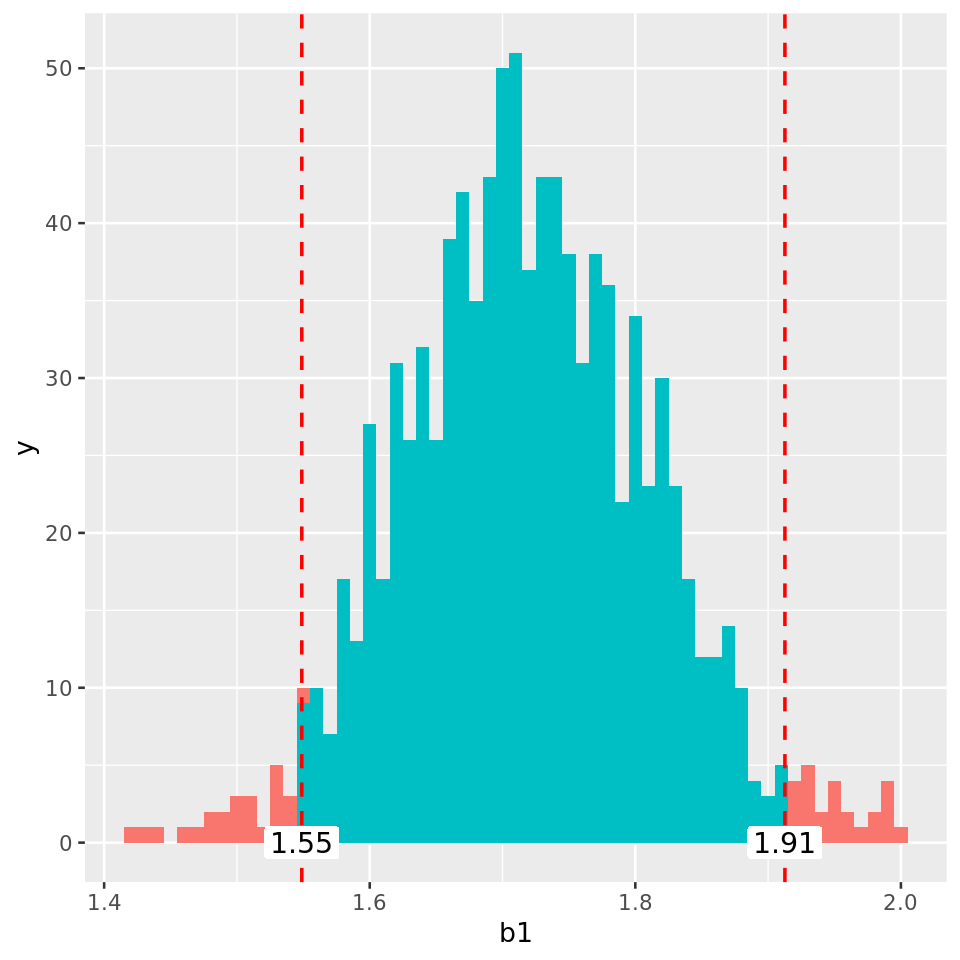

In [22]:
boot_b1_lower <- quantile(boot_coef$b1, 0.025)
boot_b1_upper <- quantile(boot_coef$b1, 0.975)

boot_coef %>% ggplot(aes(x=b1)) + 
              geom_histogram(aes(fill=(b1>=boot_b1_lower &
                                       b1<=boot_b1_upper)),
                             binwidth=0.01) +
              geom_vline(xintercept = boot_b1_lower, color="red", linetype="dashed", size=1) +
              geom_vline(xintercept = boot_b1_upper, color="red", linetype="dashed", size=1) +
              annotate("label", x= boot_b1_lower, y = 0, label=round(boot_b1_lower,2), size=6, label.size=NA) +
              annotate("label", x= boot_b1_upper, y = 0, label=round(boot_b1_upper,2), size=6, label.size=NA) + 
              theme_grey(base_size=16) +
              theme(legend.position="none")

---
## 2. Analytical approach

In the analytical approach, the null distribution and the confidence intervals are not derived from resampling but are calculated from a theoretical distribution, in this case, the t-distribution

### Significance testing of coefficients

We will calculate the t-statistic for the coefficients and use them to find the p-values from the null t-distribution

$$t_{b_0} = \frac{b_0}{\operatorname{SE}(b_{0})}$$
$$t_{b_1} = \frac{b_1}{\operatorname{SE}(b_{1})}$$

#### 2.1. Calculate the test statistic

Consider the error term in a linear model

$$\hat{y}_{i} = b_0 + b_1 x_{i} + \varepsilon_{i}$$

The variance of the error term $s^2$ can be estimated using the residual values, which are the differences between the actual value and the fitted value from the model

$$s^{2} = \frac{1}{n-2} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2} = \frac{\mathit{SS}_\text{residuals}}{n-2}$$

The standard errors of the coefficients can be calculated from $s^2$

$$\operatorname{SE}(b_{1})=\sqrt{\frac{s^{2}}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}}} =
\sqrt{\frac{s^{2}}{\mathit{SS}_\text{xx}}}$$


$$\operatorname{SE}(b_{0}) = \sqrt{\frac{1}{n} \frac{s^{2}\sum_{i=1}^{n} x_{i}^{2}}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}}}
= \operatorname{SE}(b_{1})\sqrt{\frac{\sum_{i=1}^{n} x_{i}^{2}}{n}} = \operatorname{SE}(b_{1})\sqrt{\frac{\mathit{SS}_\text{x}}{n}}
$$

Finally, we can calculate the t-statistic using the standard errors

$$t_{b_0} = \frac{b_0}{\operatorname{SE}(b_{0})}$$
$$t_{b_1} = \frac{b_1}{\operatorname{SE}(b_{1})}$$

We use the `lm` function to obtain the predicted values and the coefficients needed to calculate the t-statistic

In [23]:
# find intercept b0 and slope b1

fit_BMI <- lm(sysBP ~ BMI, BMI_sysBP) 

b0 <- fit_BMI$coefficients[1]  # 1st = intercept, 2nd = slope
b1 <- fit_BMI$coefficients[2]   

# calculate t-statistic for intercept and slope

t_stat <- BMI_sysBP %>% 
          rename(y = sysBP,    # y = dependent variable                       
                 x = BMI       # x = independent variable
                 ) %>%                     
          mutate(residual = y - (b0 + b1 * x),     # calculate residuals
                 ) %>% 
          summarize(n=n(),                         # n
                    mean_x = mean(x),              # mean of x 
                    ss_x = sum(x^2),               # sum squares of x
                    ss_xx = sum((x-mean_x)^2),     # sum square of diff x and mean of x
                    var = sum(residual^2)/(n-2),   # overall variance (df = n-2)

                    se_b1 = sqrt(var/ss_xx),       # standard error b1
                    se_b0 = se_b1 * sqrt(ss_x/n),  # standard error b0

                    t_b0 = b0/se_b0,               # t-stat b0
                    t_b1 = b1/se_b1                # t-stat b1
                    )

t_stat %>% select(se_b0, se_b1, t_b0, t_b1)

se_b0,se_b1,t_b0,t_b1
<dbl>,<dbl>,<dbl>,<dbl>
2.178396,0.08373255,39.96899,20.55403


#### 2.2. Use the theoretical null distribution to calculate the p-value

The null t distribution is parameterized by the degrees of freedom `df`

- `df` = number of samples - number of parameters

In [24]:
df <- t_stat$n - 2
df

[1] 3545

We use the `vdist_t_prob` function from the `vistributions` library to plot the t-distribution parameterized by `df` and t-statistic for the `intercept` and `BMI`

- intercept

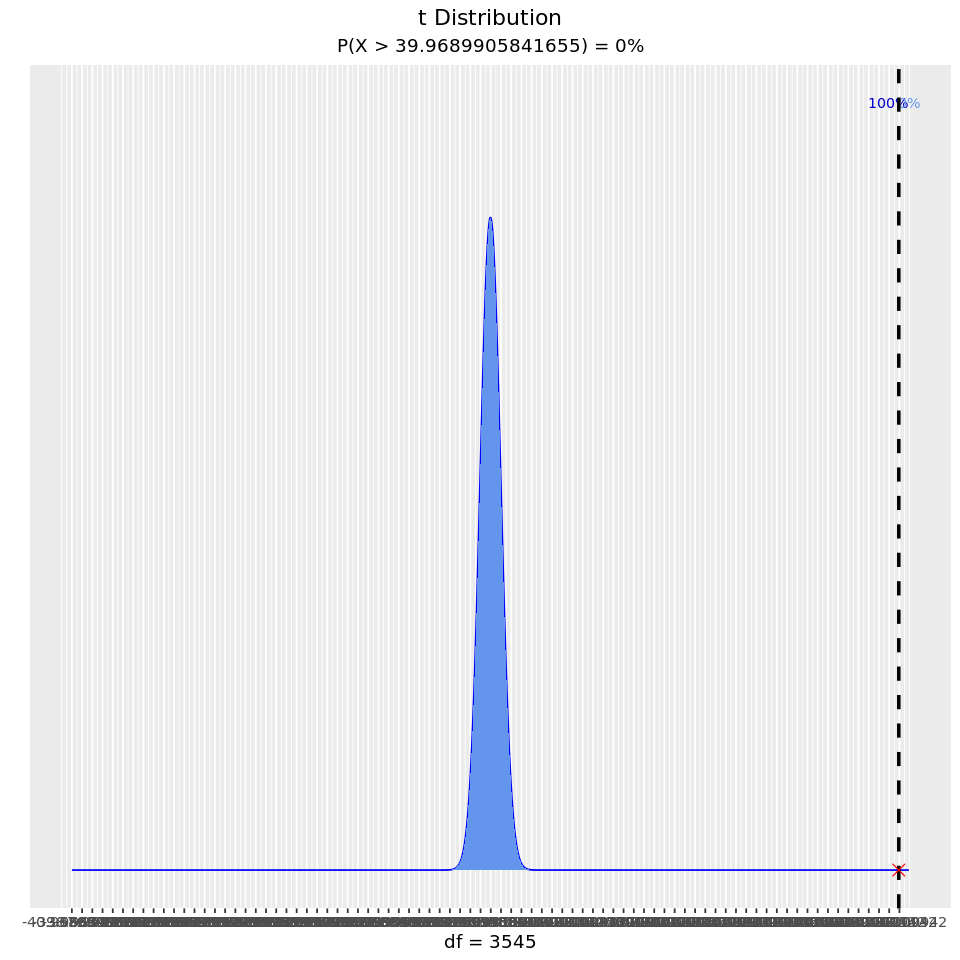

In [25]:
library(vistributions)

vdist_t_prob(perc = t_stat$t_b0, df = df, type="upper")

- BMI

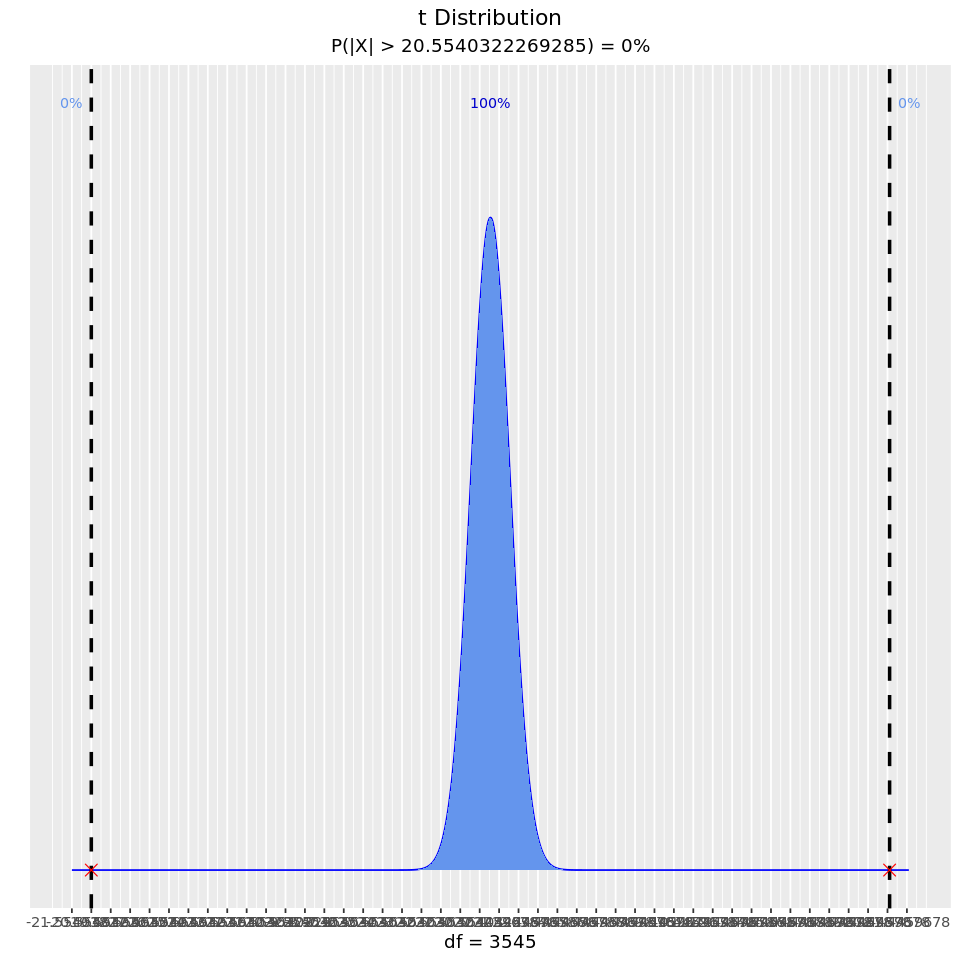

In [26]:
vdist_t_prob(perc = t_stat$t_b1, df = df, type="both")

### Confidence interval of coefficients

Recall that the 95% confidence interval is defined as

$$\bar{x}-t_\mathit{lower}\times{SE} \leq \mu \leq \bar{x}+t_\mathit{upper}\times{SE}$$

$$
\begin{align}
\text{where } \mu &= \text{population mean of intercept/coefficient}\\
\bar{x} &= \text{sample mean of intercept/coefficient}\\
SE &= \text{standard error } \frac{s}{\sqrt{n}}\\
t_\mathit{lower} &= 2.5 \text{ percentile t-score}\\
t_\mathit{upper} &= 97.5 \text{ percentile t-score}
\end{align}
$$

The lower and upper t-scores are obtained using the `qt` function for the degree of freedom $\mathit{df}$

In [27]:
lower_t_score <- qt(0.025, df = df)
upper_t_score <- qt(0.975, df = df)

tibble(percentile=c("0.025","0.975"),
       t_score=c(lower_t_score,upper_t_score))

percentile,t_score
<chr>,<dbl>
0.025,-1.960633
0.975,1.960633


**intercept**
- `lower`: intercept + t_score(0.025) x std error of intercept
- `upper`: intercept + t_score(0.975) x std error of intercept

In [28]:
# 95% CI for b0

b0 + lower_t_score * t_stat$se_b0
b0 + upper_t_score * t_stat$se_b0

(Intercept) 
   82.79726

(Intercept) 
   91.33933

**BMI**
- `lower`: BMI + t_score(0.025) x std error of BMI
- `upper`: BMI + t_score(0.975) x std error of BMI

In [29]:
# 95% CI for b1

b1 + lower_t_score * t_stat$se_b1
b1 + upper_t_score * t_stat$se_b1

BMI 
1.556873

BMI 
1.88521

### Using library functions

We can also use the `lm` function to obtain the estimates and the _p-values_

In [30]:
fit_BMI <- lm(sysBP ~ BMI, BMI_sysBP)

broom::tidy(fit_BMI) # tidy summary of model

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),87.068295,2.17839615,39.96899,1.037545e-288
BMI,1.721042,0.08373255,20.55403,8.752219e-89


To get the confidence intervals of the coefficients, we use the `confint` function on the `lm` object

In [31]:
confint(fit_BMI)

,2.5 %,97.5 %
(Intercept),82.797259,91.33933
BMI,1.556873,1.88521


---
## How well does the model fit the data?

We can assess how well the model fits the data by looking at
- goodness of fit measures:  $R^2$ and adjusted $R^2$
- diagnostic plots of the residuals after fitting

### 1. Goodness of fit

![lm_r2.png](images/lm_r2.png)

We can estimate the goodness of fit to the data by considering the following

- The sum squared differences between $y$ and the overall mean $\bar{y}$

$$S S_{\mathrm{total}}=\sum_{i}\left(y_{i}-\bar{y}\right)^{2}$$

- The sum squared differences between $y$ and the fitted(predicted) value $\hat{y}$

$$S S_{\mathrm{residual}}=\sum_{i}\left(y_{i}-\hat{y}_{i}\right)^{2}$$

The goodness of fit $R^2$ is defined as

$$R^{2}=1-\frac{S S_{\mathrm{residual}}}{S S_{\mathrm{total}}}$$

Using these definitions, we can calculate the $SS_\text{residual}$ and $SS_\text{total}$ from the data to obtain $R^2$

In [32]:
data_fit <- tibble(y=data$sysBP, 
                   x=data$BMI,
                   y_mean=mean(y),
                   y_hat=fit_BMI$fitted.values) %>%
            mutate(mean_y = mean(y),
                   s_total = (y - mean_y)^2,
                   s_residual = (y - y_hat)^2) 


data_fit %>% summarize(ss_total = sum(s_total),
                       ss_residual = sum(s_residual),
                       r2 = 1 - (ss_residual/ss_total)) %>%
             head

ss_total,ss_residual,r2
<dbl>,<dbl>,<dbl>
1578362,1410293,0.1064831


The $R^2$ can be interpreted as the amount of variance in the data explained by the model. This estimate may be **biased** as _the number of parameters (covariates) in the model increases_ 

The unbiased estimator adjusted $R^2$ accounts for the increase in parameters and is defined as

$$\bar{R}^{2}=1-\frac{S S_{\text {res }} / \mathrm{df}_{e}}{S S_{\text {tot }} / \mathrm{df}_{t}}$$

$$
\begin{align}
\text{where }\mathit{df}_t &= \text{number of samples} - 1 \\
\mathit{df}_e &= \text{number of samples} - \text{number of parameters} - 1
\end{align}
$$

In [33]:
num_covariates <- 1
num_samples <- nrow(data)

df_total <- num_samples - 1
df_residual <- num_samples - num_covariates - 1

data_fit %>% summarize(ss_total = sum(s_total),
                       ss_residual = sum(s_residual),
                       r2 = 1 - (ss_residual/ss_total),
                       adj_r2 = 1 - ((ss_residual/df_residual)/(ss_total/df_total)))

ss_total,ss_residual,r2,adj_r2
<dbl>,<dbl>,<dbl>,<dbl>
1578362,1410293,0.1064831,0.106231


**Using a function**

We can extract the $R^2$ and adjusted $R^2$ values from the `lm` object by using the `summary` function

In [34]:
summary(fit_BMI)$r.squared
summary(fit_BMI)$adj.r.squared

[1] 0.1064831

[1] 0.106231

### 2. Diagnostic plots

We can also assess the model fit by looking at diagnostic plots using the `autoplot` function from the `ggfortify` library

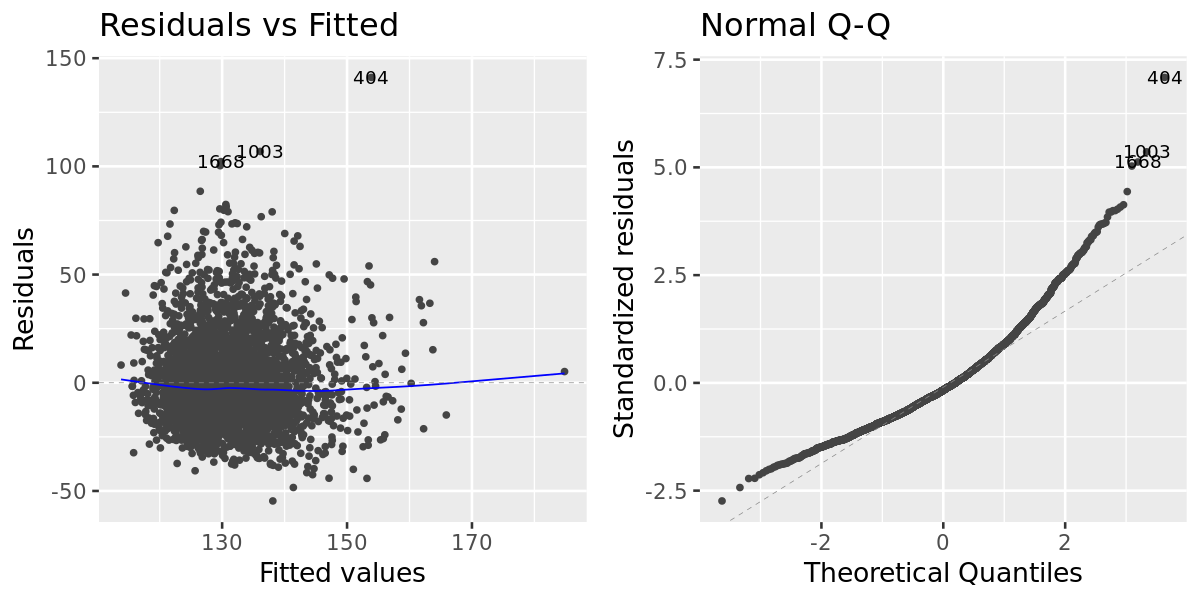

In [35]:
library(ggfortify)

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=5)

fit_BMI %>% autoplot(which = 1:2) + # show only first 2 plots
            theme_grey(base_size=16)

1. **Residuals vs Fitted**
- Residuals hover around the 0 line indicating linear fit is appropriate
- Residuals roughly cluster along a horizontal band indicating variances are equal
- No significant outliers

![lm_diagnostic.png](images/lm_diagnostic.png)

For details see: https://stats.stackexchange.com/questions/76226/interpreting-the-residuals-vs-fitted-values-plot-for-verifying-the-assumptions

2. **QQ plot of residuals**
- Residuals are roughly normally distributed

---
# Application: Statistical table and plotting

We will be using these libraries for making statistical tables  and plots for the linear models
- `stargazer`: statistical tables for models
- `ggstatsplot`: plotting of the model coefficients
- `ggfortify`: diagnostic plots for models

To illustrate how we use them, we will build a simple model looking at the relationship between `sysBP` and `BMI` variables in the Framingham dataset

In [ ]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na

BMI_sysBP <- data %>% select(BMI, sysBP)

head(BMI_sysBP)

In [ ]:
# build model

fit_BMI <- lm(sysBP ~ BMI, BMI_sysBP)

## 1. Statistical table

We will use the `stargazer` function from the `stargazer` library to generate a statistical table from the model. The function can take one or more models as its input and we can specify the following options
- `ci`: set to TRUE to print the confidence intervals
- `type`: set to HTML to print the table in the notebook

We will define a local function `print_html` to print the HTML output from `stargazer` in the notebook

In [ ]:
# print html convenience function

print_html <- function(input) {
    
    capture.output(input) %>% 
    paste(collapse="") %>% 
    IRdisplay::display_html()
    
}

In [ ]:
# print stargazer table

library(stargazer)

stargazer(fit_BMI, ci=TRUE, type="html") %>% print_html

## 2. Statistical plot

We will use the `ggcoefstats` function from `ggstatsplot` to generate a plot of the coefficients with the confidence intervals and the associated p-values. We can specify the following options
- `exclude.intercept`: set to TRUE to omit the intercept
- `stats.label.args`: provide a list of options for the labels if desired

In [ ]:
library(ggstatsplot)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

fit_BMI %>% ggcoefstats(exclude.intercept = T,
                         stats.label.args=list(nudge_y=0.1, 
                                               size=5, label.size=NA)) +
                          theme_grey(base_size=16)

## 3. Diagnostic plot

We will use the `autoplot` function from the `ggfortify` library to generate basic diagnostic plots of the residuals. For simplicity, we specify the option `which = 1:2` to limit the plots to
- Residuals vs Fitted
- Normal Q-Q

In [ ]:
library(ggfortify)

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=5)

fit_BMI %>% autoplot(which = 1:2) + 
            theme_grey(base_size=16)

---
## Exercise - Modeling (Simple)

For this exercise, we will use the Framingham dataset and model the relationship between `totChol` and `BMI`

In [ ]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na

BMI_totChol <- data %>% select(BMI, totChol)

head(BMI_totChol)

We will define a local function `print_html` to print the HTML output from `stargazer` in the notebook

In [ ]:
# print html convenience function

print_html <- function(input) {
    
    capture.output(input) %>% 
    paste(collapse="") %>% 
    IRdisplay::display_html()
    
}

### Part 1

Build a linear model using the `lm` function and store it as `myfit_BMI`
- `totChol`: dependent/response variable
- `BMI`: independent/explanatory variable

Create a `stargazer` table and print it
- Explain the coefficients
- Explain the model fit

In [ ]:
library(stargazer)

# start here

In [ ]:
# solution

myfit_BMI <- lm(totChol ~ BMI, BMI_totChol)

stargazer(myfit_BMI, ci = T, type="html") %>% print_html

### Part 2

Use `ggcoefstats` to plot the coefficient(s) in the model. You may exclude the intercept from the plot

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

myfit_BMI %>% ggcoefstats(exclude.intercept = T)

### Part 3

Create a diagnostic plot for the model using `autoplot` from `ggfortify`
- Interpret the plot

In [ ]:
library(ggfortify)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=4)

myfit_BMI %>% autoplot(which=1:2)